In [1]:
import os
import sys
import numpy as np 
import pandas as pd
from scipy import stats, signal, io
import mne
from mne import create_info, EpochsArray
from mne.time_frequency import tfr_morlet
from bids import BIDSLayout
import mne_bids
import scipy
import json
from sklearn import linear_model, metrics
import multiprocessing
from sklearn.model_selection import cross_val_score
from sklearn import ensemble, model_selection
from matplotlib import pyplot as plt
import matplotlib 
import seaborn as sn

font = {'size'   : 12}
matplotlib.rc('font', **font)

PLT_SUPPLEMENTS_PATH = r'C:\Users\ICN_admin\Documents\ECOGVSTN\plot supplements'

# read plotting mat structures 
faces = io.loadmat(os.path.join(PLT_SUPPLEMENTS_PATH, 'faces.mat'))
Vertices = io.loadmat(os.path.join(PLT_SUPPLEMENTS_PATH, 'Vertices.mat'))
grid = io.loadmat(os.path.join(PLT_SUPPLEMENTS_PATH, 'grid.mat'))['grid']
stn_surf = io.loadmat(os.path.join(PLT_SUPPLEMENTS_PATH, 'STN_surf.mat'))
x_ = stn_surf['vertices'][::2,0]
y_ = stn_surf['vertices'][::2,1]
x_ecog = Vertices['Vertices'][::1,0]
y_ecog = Vertices['Vertices'][::1,1]
x_stn = stn_surf['vertices'][::1,0]
y_stn = stn_surf['vertices'][::1,1]

BIDS_PATH = r'C:\Users\ICN_admin\Documents\ECOGVSTN\data\BIDS_PITTSBURGH'

# from the BIDS Path Pittsburgh Gripforce we're only using a subset of patients
subject_id = ['000', '001', '004', '005', '006', '007', '008', '009', '010', '013', '014']

#002 - DBS4011 - no locaization possible
#003 - DBS4020 - LEFT due to signal quality
#011 - DBS4037 - STN was not recorded
#012 - DBS4030 - GPi not STN 
#015 - DBS4065 - LEFT due to signal quality

# read from BIDS all electrode data 


In [6]:
layout = BIDSLayout(BIDS_PATH)

C:\Users\ICN_admin\Anaconda3\lib\site-packages\bids\layout\models.py:152: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


In [4]:
def get_electrodes(sub, ch_type, space, bids_path, layout):
    """Returns pandas dataframe of electrodes of a given subject in a BIDS root directory

    Args:
        sub (string): BIDS subject
        ch_type (string): BIDS specific channel type in channels.tsv
        space (string) : BIDS specific electrode space
        bids_path (string): BIDS root directory
        layout (pybids BIDSLayout) : can be previously allocated to save time in repetitive iteration

    Returns:
        pandas dataframe: run concatenated electrode tsv dataframe for given subject and channel type
    """

    if layout is None:
        layout = BIDSLayout(bids_path)

    channels = layout.get(subject=sub, extension='.tsv', suffix='channels')
    electrodes = layout.get(subject=sub, space=space, extension='.tsv', suffix='electrodes')

    if len(channels) != len(electrodes):
        assert False, "channel.tsv length and electrodes.tsv does not match"

    df_electrodes = pd.DataFrame()

    for channel_file, electrode_file in zip(channels, electrodes):
        df_run = electrode_file.get_df()[np.array(channel_file.get_df()["type"] == ch_type)]
        df_electrodes = pd.concat([df_electrodes,df_run]).drop_duplicates().reset_index(drop=True)    
        
    return df_electrodes

In [2]:
hue_colors = sn.color_palette(palette="Paired", n_colors=11)

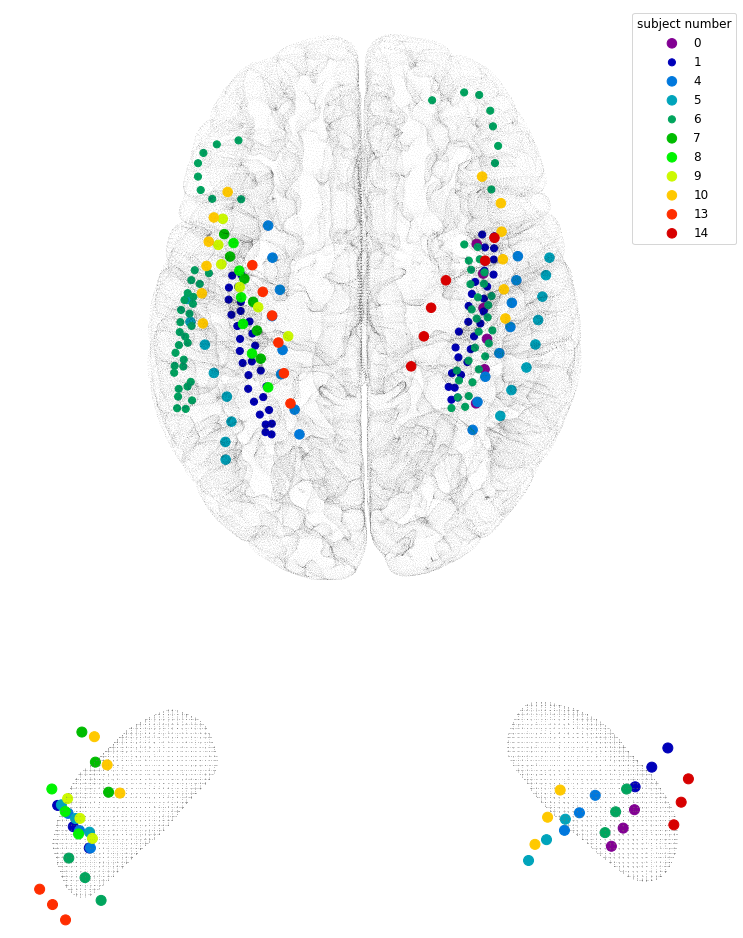

In [10]:
hue_colors = sn.color_palette("nipy_spectral", len(subject_id))
height_STN = 1
height_ECOG = 2.5*height_STN
colormap_ = "jet"
fig, axes = plt.subplots(2,1, facecolor=(1,1,1), gridspec_kw={'height_ratios': [height_ECOG, height_STN]},\
                             figsize=(17,17))#,dpi=700)

for sub_idx, subject_id_ in enumerate(subject_id):    

    axes[0].scatter(x_ecog, y_ecog, c="gray", s=0.000005)
    axes[0].set_axis_off()
    df_coord = get_electrodes(sub=subject_id_, ch_type="ECOG", space="mni", \
                                    layout=layout, bids_path=BIDS_PATH)[["x", "y"]]*1000

    c = np.ones(df_coord.shape[0])

    if subject_id_ == '001' or subject_id_ == '006': # smaller size
        pos_ecog = axes[0].scatter(df_coord["x"], df_coord["y"], #
                                   c=np.tile(hue_colors[sub_idx], reps=(df_coord["x"].shape[0],1)), 
                                   s=50, cmap=colormap_, label=str(int(subject_id_)))
    else:
        pos_ecog = axes[0].scatter(df_coord["x"], df_coord["y"], 
                                   c=np.tile(hue_colors[sub_idx], reps=(df_coord["x"].shape[0],1)),
                                   s=90, cmap=colormap_, label=str(int(subject_id_)))
    
    
    #cbar_ecog = fig.colorbar(pos_ecog, ax=axes); pos_ecog.set_clim(1,1.4); cbar_ecog.remove()

    df_coord = get_electrodes(sub=subject_id_, ch_type="SEEG", \
                                       layout=layout, space="mni", bids_path=BIDS_PATH)[["x", "y"]]*1000
    pos_stn = axes[1].scatter(x_stn, y_stn, c="gray", s=0.0001)

    if subject_id_ not in ['012', '003']:

        c = np.ones(df_coord.shape[0])

        pos_stn = axes[1].scatter(df_coord["x"], df_coord["y"],
                                  c=np.tile(hue_colors[sub_idx], reps=(df_coord["x"].shape[0],1)),
                                  s=100, cmap=colormap_)
    #cbar_stn = fig.colorbar(pos_stn, ax=axes[y_cnt_STN, x_cnt_STN]); pos_stn.set_clim(1,1.4); cbar_stn.remove()

    axes[0].axes.set_aspect('equal', anchor='C')
    axes[0].set_facecolor((1,1,1))
    axes[0].set_axis_off()
    axes[1].axes.set_aspect('equal', anchor='C')
    axes[1].set_facecolor((1,1,1))
    axes[1].set_axis_off()
axes[0].legend(title="subject number", bbox_to_anchor=(1.05, 1))

plt.savefig("Figure 1 All Contacts.pdf", bbox_inches='tight')